<a href="https://colab.research.google.com/github/gpan79/DeepLearning/blob/main/ANN_House_Price_Prediction_RandomizedSearchCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sklearn
if (sklearn.__version__ != '0.24.2'):
  !pip uninstall scikit-learn -y
  !pip install -U scikit-learn
else:
  print("Scikit-Learn updated to last version: ", sklearn.__version__)

Scikit-Learn updated to last version:  0.24.2


In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score
#from sklearn.metrics import mean_squared_error, explained_variance_score
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
import pytz

In [ ]:
# Verifica Accelerazione GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Monta Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Save filename
# pytz TimeZone Localization
tz_EuRome = pytz.timezone('Europe/Rome')
datetime_EuRome = datetime.now(tz_EuRome)
current_time = datetime_EuRome.strftime("%m-%d-%Y_%H-%M")
#print(current_time)
saveFileName = "model_saved_" + current_time + ".h5"
pathSaveModel = F"/content/gdrive/My Drive/MaBiDa_2021/saved_models/{saveFileName}"
print("Best Model will be saved as file: ", pathSaveModel)

Best Model will be saved as file:  /content/gdrive/My Drive/MaBiDa_2021/saved_models/model_saved_05-16-2021_23-50.h5


In [ ]:
# Importa il dataset
from google.colab import files
import io
import os

df = pd.read_csv('/content/gdrive/My Drive/MaBiDa_2021/dataset/kc_house_data.csv')

Features:  ['id' 'date' 'price' 'bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot'
 'floors' 'waterfront' 'view' 'condition' 'grade' 'sqft_above'
 'sqft_basement' 'yr_built' 'yr_renovated' 'zipcode' 'lat' 'long'
 'sqft_living15' 'sqft_lot15']
           id             date     price  ...     long  sqft_living15  sqft_lot15
0  7129300520  20141013T000000  221900.0  ... -122.257           1340        5650
1  6414100192  20141209T000000  538000.0  ... -122.319           1690        7639
2  5631500400  20150225T000000  180000.0  ... -122.233           2720        8062
3  2487200875  20141209T000000  604000.0  ... -122.393           1360        5000
4  1954400510  20150218T000000  510000.0  ... -122.045           1800        7503

[5 rows x 21 columns]


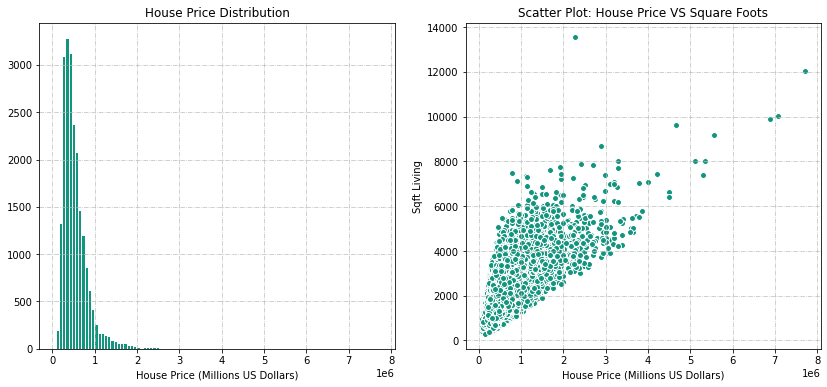

In [ ]:
print("Features: ", df.columns.values)

# Visualizza una preview dei dati
print(df.head())

# Cancella righe con dati mancanti o NaN
df.dropna(axis=0, how='any')

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].hist(df['price'], bins=100, color='#12947e', edgecolor='white')
ax[1].scatter(df['price'], df['sqft_living'], color='#12947e', edgecolors='white')
ax[0].set(xlabel='House Price (Millions US Dollars)', ylabel='', title='House Price Distribution')
ax[1].set(xlabel='House Price (Millions US Dollars)', ylabel='Sqft Living',
          title='Scatter Plot: House Price VS Square Foots')
ax[0].grid(color='#b8bfbd', linestyle='-.', linewidth=0.7)
ax[1].grid(color='#b8bfbd', linestyle='-.', linewidth=0.7)
plt.show(block=False)

In [ ]:
# Elimina Features non utili
df = df.drop('id', axis=1)
df = df.drop('zipcode', axis=1)
df = df.drop('date', axis=1)

# Features finali
X = df.drop('price', axis=1)

# Label
y = df['price']

# Eliminare dal dataset la prima riga e salvarla come nuovo record per la predizione finale
house_to_predict = df.drop('price', axis=1).iloc[0]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Definizione dello scaler per normalizzare i dati
scaler = MinMaxScaler()

# Normalizzare i dati sulla dinamica del dataset di Training (per non avere data leakage!)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Max: ', X_train.max())
print('Min: ', X_train.min())


(15129, 17)
(6484, 17)
(15129,)
(6484,)
Max:  1.0000000000000002
Min:  0.0


In [ ]:
# Definizione e implementazione del modello FFNN con Keras
def createModel(nn1, nn2, nn3, learning_rate):
    model = Sequential()
    model.add(Dense(nn1, activation='swish'))
    model.add(Dense(nn2, activation='swish'))
    model.add(Dense(nn3, activation='swish'))
    model.add(Dense(1))
    model.compile(optimizer=tf.optimizers.Adam(lr=learning_rate), loss='mse')
    return model

def gridTrain(train_x, train_y):
    number_of_neurons_input_layer = [16, 32, 64]
    number_of_neurons_first_hidden_layer = [64, 128, 256]
    number_of_neurons_second_hidden_layer = [256, 512]
    learning_rate = [0.05, 0.005, 0.0005, 0.00005]
    batch_size = [32, 64, 128, 256, 512]
    epochs = [100, 200, 300, 500]

    parameters = dict(nn1=number_of_neurons_input_layer,
                      nn2=number_of_neurons_first_hidden_layer,
                      nn3=number_of_neurons_second_hidden_layer,
                      learning_rate=learning_rate,
                      batch_size=batch_size,
                      epochs=epochs)

    with(tf.device('/GPU:1')):
        modelCV = KerasRegressor(build_fn=createModel)
        grid = RandomizedSearchCV(modelCV, parameters, n_jobs=1, verbose=50, scoring='r2')
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=10,
                                                    restore_best_weights=True)

        # filepathCheckPoint="/content/gdrive/My Drive/MaBiDa_2021/models_checkpoint/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
        save = tf.keras.callbacks.ModelCheckpoint(filepathCheckPoint, monitor='val_loss',
                                                  mode='auto',
                                                  save_best_only=True,
                                                  save_weights_only=False, verbose=1)

        grid.fit(train_x, train_y, validation_split=0.15, callbacks=[callback, save])

        print("\n\n Best Model After Randomized-Search Cross Validation: ")
        print(grid.best_score_, grid.best_params_)
        print("\n\n")
        means = grid.cv_results_['mean_test_score']
        parameters = grid.cv_results_['params']
        for mean, parameter in zip(means, parameters):
            print(mean, parameter)

    return grid.best_estimator_.model, grid.best_params_, means, parameters

Output streaming troncato alle ultime 5000 righe.

Epoch 00319: val_loss did not improve from 12225602560.00000
Epoch 320/500
81/81 [==============================] - 0s 4ms/step - loss: 83072576137.3659 - val_loss: 66862669824.0000

Epoch 00320: val_loss did not improve from 12225602560.00000
Epoch 321/500
81/81 [==============================] - 0s 3ms/step - loss: 82861180078.8293 - val_loss: 66634407936.0000

Epoch 00321: val_loss did not improve from 12225602560.00000
Epoch 322/500
81/81 [==============================] - 0s 4ms/step - loss: 86850570090.1463 - val_loss: 66398789632.0000

Epoch 00322: val_loss did not improve from 12225602560.00000
Epoch 323/500
81/81 [==============================] - 0s 4ms/step - loss: 78761714663.0244 - val_loss: 66164121600.0000

Epoch 00323: val_loss did not improve from 12225602560.00000
Epoch 324/500
81/81 [==============================] - 0s 4ms/step - loss: 78030912636.8781 - val_loss: 65923530752.0000

Epoch 00324: val_loss did not impr

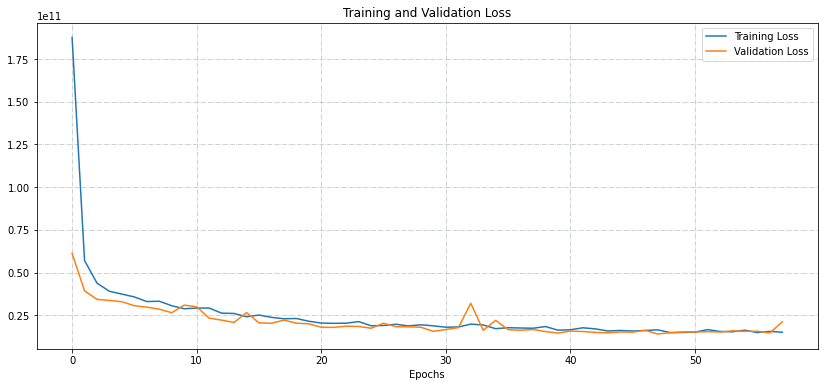

In [ ]:
model, params, means, parameters  = gridTrain(X_train, y_train.values)
model.save(pathSaveModel, save_format='h5')
for mean, parammeter in zip(means, parameters):
    print("\nMean Test Score: ", mean, " for Parameters: ", parameters)

losses = pd.DataFrame(model.history.history)

plt.figure(figsize=(14, 6))
plt.plot(losses['loss'], label="Training Loss")
plt.plot(losses['val_loss'], label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training and Validation Loss')
plt.legend(loc="upper right")
plt.grid(color='#b8bfbd', linestyle='-.', linewidth=0.7)
plt.show(block=False)

In [ ]:
# Computo delle predizioni sul dataset di Test
predictions = model.predict(X_test)

print('MAPE: ', mean_absolute_percentage_error(y_test, predictions))
print('Variance Regression Score: ', explained_variance_score(y_test, predictions))

# Normalizza le feature del record per la predizione out-of-sample
house_to_predict = scaler.transform(house_to_predict.values.reshape(-1, X.shape[1]))

# Esegue la predizione out-of-sample e stampa il prezzo predetto
print('\nPredicted Price:', model.predict(house_to_predict)[0, 0])

# Stampa del prezzo reale
print('\nOriginal Price:', df.iloc[0]['price'])

MAPE:  0.14758108760203584
Variance Regression Score:  0.8802752071248292

Predicted Price: 271296.06

Original Price: 221900.0
